In [1]:
%matplotlib inline

Analytic 300-hPa Trough
=======================


In [2]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np


Below are three definitions to create an analytic 300-hPa trough roughly
based on the Sanders Analytic Model with modified coefficients to create
different style waves.


In [3]:
def single_300hPa_trough(parameter='hght'):
    """ Single trough with heights and Temperatures based on Sanders Analytic Model
    """
    X = np.linspace(.25, .75, 101)
    Y = np.linspace(.25, .75, 101)

    x, y = np.meshgrid(X, Y)

    p = 4
    q = 2

    if parameter == 'hght':
        return (9240 + 100 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 200 * np.cos(y * np.pi) + 300 * y * np.cos(x * np.pi + np.pi / 2))
    elif parameter == 'temp':
        return (-50 + 2 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 2 * np.cos(y * np.pi) + 0.5 * y * np.cos(x * np.pi + np.pi / 2))


def lifting_300hPa_trough(parameter='hght'):
    """ Lifting trough with heights and Temperatures based on Sanders Analytic Model
    """
    X = np.linspace(.25, .75, 101)
    Y = np.linspace(.25, .75, 101)

    x, y = np.meshgrid(X, Y)

    p = 4
    q = 2

    if parameter == 'hght':
        return (9240 + 150 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 200 * np.cos(y * np.pi) + 400 * y * np.cos(x * np.pi + np.pi))
    elif parameter == 'temp':
        return (-50 + 2 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 2 * np.cos(y * np.pi) + 5 * y * np.cos(x * np.pi + np.pi))


def digging_300hPa_trough(parameter='hght'):
    """ Digging trough with heights and Temperatures based on Sanders Analytic Model
    """
    X = np.linspace(.25, .75, 101)
    Y = np.linspace(.25, .75, 101)

    x, y = np.meshgrid(X, Y)

    p = 4
    q = 2

    if parameter == 'hght':
        return (9240 + 150 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 200 * np.cos(y * np.pi) + 400 * y * np.sin(x * np.pi + 5 * np.pi / 2))
    elif parameter == 'temp':
        return (-50 + 2 * np.cos(p * x * np.pi) * np.cos(q * y * np.pi)
                + 2 * np.cos(y * np.pi) + 5 * y * np.sin(x * np.pi + np.pi / 2))


Call the appropriate definition to develop the desired wave.


In [4]:
# Single Trough
Z = single_300hPa_trough(parameter='hght')
T = single_300hPa_trough(parameter='temp')

# Lifting Trough
# Z = lifting_300hPa_trough(parameter='hght')
# T = lifting_300hPa_trough(parameter='temp')

# Digging Trough
# Z = digging_300hPa_trough(parameter='hght')
# T = digging_300hPa_trough(parameter='temp')


Set geographic parameters for analytic grid to then


In [5]:
lats = np.linspace(35, 50, 101)
lons = np.linspace(260, 290, 101)
lon, lat = np.meshgrid(lons, lats)

# Calculate Geostrophic Wind from Analytic Heights
f = mpcalc.coriolis_parameter(lat * units('degrees'))
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
ugeo, vgeo = mpcalc.geostrophic_wind(Z*units.meter, f, dx, dy, dim_order='yx')

# Get the wind direction for each point
wdir = mpcalc.wind_direction(ugeo, vgeo)

# Compute the Gradient Wind via an approximation
dydx = mpcalc.first_derivative(Z, delta=dx, axis=1)
d2ydx2 = mpcalc.first_derivative(dydx, delta=dx, axis=1)
R = ((1 + dydx.m**2)**(3. / 2.)) / d2ydx2.m

geo_mag = mpcalc.wind_speed(ugeo, vgeo)
grad_mag = geo_mag.m - (geo_mag.m**2) / (f.magnitude * R)

ugrad, vgrad = mpcalc.wind_components(grad_mag * units('m/s'), wdir)

# Calculate Ageostrophic wind
uageo = ugrad - ugeo
vageo = vgrad - vgeo

# Compute QVectors
uqvect, vqvect = mpcalc.q_vector(ugeo, vgeo, T * units.degC, 500 * units.hPa, dx, dy)

# Calculate divergence of the ageostrophic wind
div = mpcalc.divergence(uageo, vageo, dx, dy, dim_order='yx')

# Calculate Relative Vorticity Advection
relvor = mpcalc.vorticity(ugeo, vgeo, dx, dy, dim_order='yx')
adv = mpcalc.advection(relvor, (ugeo, vgeo), (dx, dy), dim_order='yx')


Create figure containing Geopotential Heights, Temperature, Divergence
of the Ageostrophic Wind, Relative Vorticity Advection (shaded),
geostrphic wind barbs, and Q-vectors.


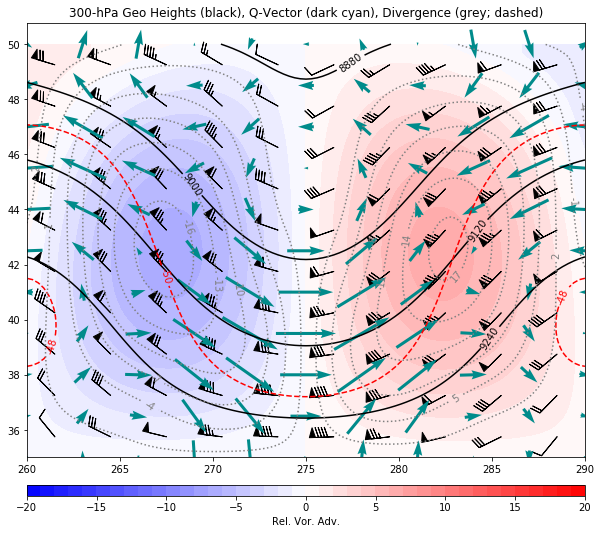

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)

# Plot Geopotential Height Contours
cs = ax.contour(lons, lats, Z, range(0, 12000, 120), colors='k')
plt.clabel(cs, fmt='%d')

# Plot Temperature Contours
cs2 = ax.contour(lons, lats, T, range(-50, 50, 2), colors='r', linestyles='dashed')
plt.clabel(cs2, fmt='%d')

# Plot Divergence of Ageo Wind Contours
cs3 = ax.contour(lons, lats, div*10**9, np.arange(-25, 26, 3), colors='grey',
                 linestyles='dotted')
plt.clabel(cs3, fmt='%d')

# Plot Rel. Vor. Adv. colorfilled
cf = ax.contourf(lons, lats, adv*10**9, np.arange(-20, 21, 1), cmap=plt.cm.bwr)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('Rel. Vor. Adv.')

# Plot Geostrophic Wind Barbs
wind_slice = slice(5, None, 10)
ax.barbs(lons[wind_slice], lats[wind_slice],
         ugeo[wind_slice, wind_slice].to('kt').m, vgeo[wind_slice, wind_slice].to('kt').m)

# Plot Ageostrophic Wind Vectors
# ageo_slice = slice(None, None, 10)
# ax.quiver(lons[ageo_slice], lats[ageo_slice],
#           uageo[ageo_slice, ageo_slice].m, vageo[ageo_slice, ageo_slice].m,
#           color='blue', pivot='mid')

# Plot QVectors
qvec_slice = slice(None, None, 10)
ax.quiver(lons[qvec_slice], lats[qvec_slice],
          uqvect[qvec_slice, qvec_slice].m, vqvect[qvec_slice, qvec_slice].m,
          color='darkcyan', pivot='mid')

plt.title('300-hPa Geo Heights (black), Q-Vector (dark cyan), Divergence (grey; dashed)')
plt.show()